In [1]:
!pip install keras==2.2.5

     |████████████████████████████████| 337kB 8.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 20.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 20.1MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessing-1.0.5:
      Successfully uninstalled Keras-Preprocessing-1.0.5
  Found existing installation: Keras-Applications 1.0.6
    Uninstalling Keras-Applications-1.0.6:
      Successfully uninstalled Keras-Applications-1.0.6
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential,Input
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.metrics import mean_absolute_error

In [29]:
import keras

In [30]:
keras.__version__

'2.2.5'

In [31]:
tf.keras.__version__

'2.2.4-tf'

In [6]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_3906e0246d7b4b60ba65f993ab87759c = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='VHv1ef_wW9NQ8kyFlLjlmRYT_4t5sjbzVL5jYTLL9_k0',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_3906e0246d7b4b60ba65f993ab87759c.get_object(Bucket='ibmhack2020-donotdelete-pr-2luk1rdgnwhitd',Key='T1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null object
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe879baa860>,
      dtype=object)

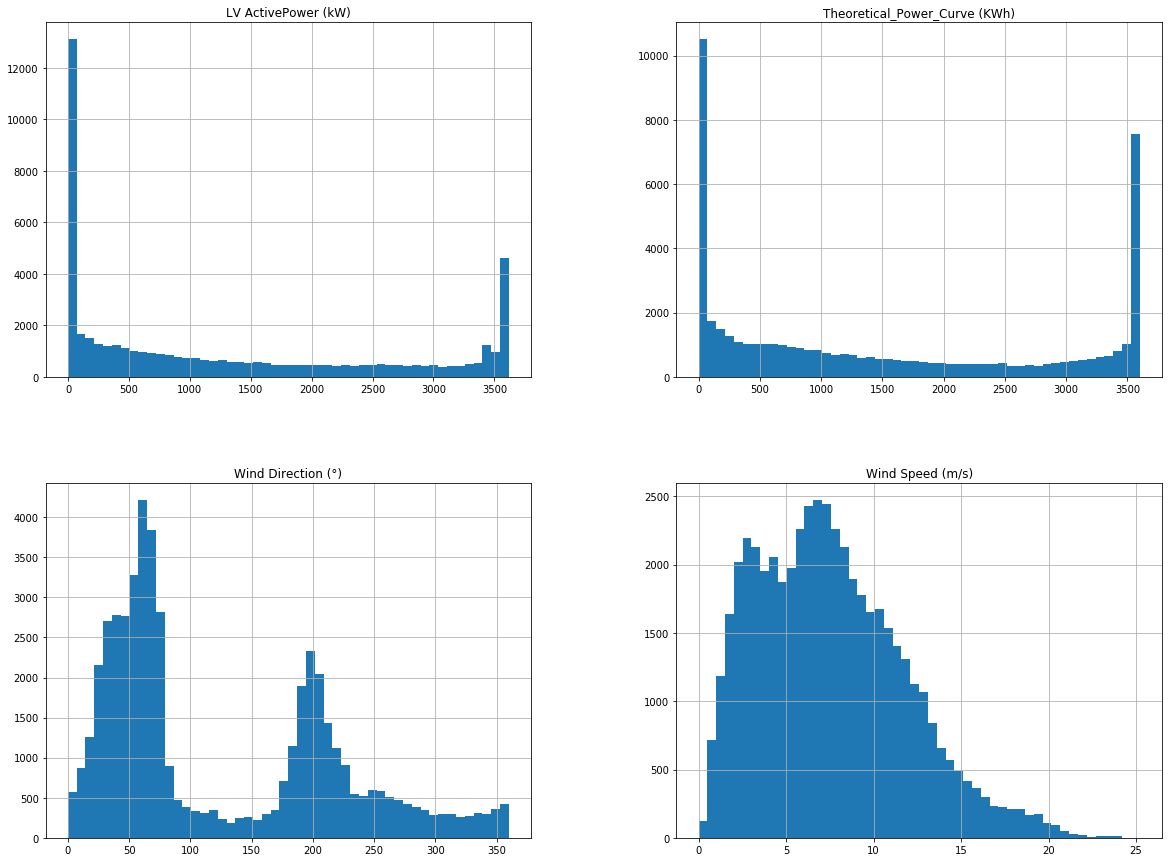

In [8]:
df.drop('Date/Time',axis = 1, inplace=True)
df.hist(bins = 50, figsize=(20,15))

In [9]:
df["Wind Speed (m/s)"].describe()

count    50530.000000
mean         7.557952
std          4.227166
min          0.000000
25%          4.201395
50%          7.104594
75%         10.300020
max         25.206011
Name: Wind Speed (m/s), dtype: float64

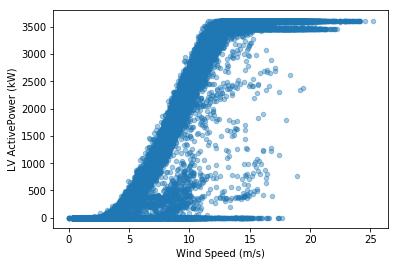

In [10]:
df.plot(kind = 'scatter', x = 'Wind Speed (m/s)', y = 'LV ActivePower (kW)',alpha = 0.4)

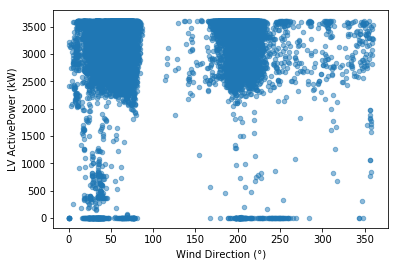

In [11]:
df[df["Wind Speed (m/s)"] >= 10].plot(kind = 'scatter', x = 'Wind Direction (°)', y = 'LV ActivePower (kW)',alpha = 0.5)

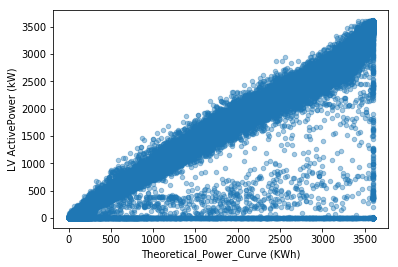

In [12]:
df.plot(kind = 'scatter', x = 'Theoretical_Power_Curve (KWh)', y = 'LV ActivePower (kW)',alpha = 0.4)

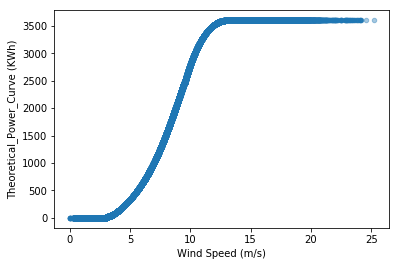

In [13]:
df.plot(kind = 'scatter', x = 'Wind Speed (m/s)', y = 'Theoretical_Power_Curve (KWh)',alpha = 0.4)

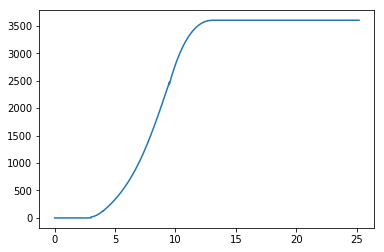

In [14]:
df2 = df.drop(axis = 1, labels =['LV ActivePower (kW)','Wind Direction (°)'])
df2.sort_values(by=['Wind Speed (m/s)'],inplace=True)
plt.plot(df2['Wind Speed (m/s)'].iloc[:].values,df2['Theoretical_Power_Curve (KWh)'].iloc[:].values)

In [15]:
X_wind_speed = df2['Wind Speed (m/s)'].iloc[:].values
Y_TPC = df2['Theoretical_Power_Curve (KWh)'].iloc[:].values 

In [16]:
#The below line estimates the expected output for the given wind speed(here 10m/s)
np.interp(10, X_wind_speed, Y_TPC)

2792.1019995808897

In [17]:
X_data = df.drop(axis = 1, labels=['LV ActivePower (kW)','Theoretical_Power_Curve (KWh)']).iloc[:].values
X_data.shape

(50530, 2)

In [18]:
Y_data = df['LV ActivePower (kW)'].iloc[:].values.reshape(-1,1)
Y_data.shape

(50530, 1)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2, random_state = 42)

In [20]:
wind_speed_max = max(X_train[:,0])
theoretical_max_output = 3600
active_power_max = max(Y_train[:,0])
degrees = 360

X_train[:,0] = np.clip(X_train[:,0], a_min=0, a_max=wind_speed_max)/wind_speed_max
X_train[:,1] = X_train[:,1]/degrees
Y_train = np.clip(Y_train,a_min=0,a_max = theoretical_max_output)/theoretical_max_output


X_test[:,0] = np.clip(X_test[:,0], a_min=0, a_max=wind_speed_max)/wind_speed_max
X_test[:,1] = X_test[:,1]/degrees
Y_test = np.clip(Y_test,a_min=0,a_max = theoretical_max_output)/theoretical_max_output

In [21]:
def model():
    model = Sequential([Dense(16, activation = 'relu', input_shape = (2,)),
                        Dense(128,activation = 'relu'),
                        BatchNormalization(),
                        Dropout(0.2),
                        Dense(64,activation = 'relu'),
                        BatchNormalization(),
                        Dropout(0.2),
                        Dense(32,activation = 'relu'),
                        BatchNormalization(),
                        Dropout(0.2),
                        Dense(8,activation = 'relu'),
                        Dense(1, activation = 'sigmoid')])
    
    model.compile(metrics = ['mae','mse'],optimizer=keras.optimizers.Adam(lr = 0.001), loss = 'mse')
    
    return model

In [22]:
model = model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2176      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________

In [23]:
history = model.fit(X_train,Y_train,epochs = 100, validation_data = (X_test, Y_test),batch_size=2048)

Instructions for updating:
Use tf.cast instead.
Train on 40424 samples, validate on 10106 samples
Epoch 1/20
40424/40424 [==============================] - 5s 119us/step - loss: 0.0515 - mean_absolute_error: 0.1557 - mean_squared_error: 0.0515 - val_loss: 0.0182 - val_mean_absolute_error: 0.0637 - val_mean_squared_error: 0.0182
Epoch 2/20
40424/40424 [==============================] - 1s 31us/step - loss: 0.0187 - mean_absolute_error: 0.0806 - mean_squared_error: 0.0187 - val_loss: 0.0174 - val_mean_absolute_error: 0.0610 - val_mean_squared_error: 0.0174
Epoch 3/20
40424/40424 [==============================] - 3s 63us/step - loss: 0.0172 - mean_absolute_error: 0.0726 - mean_squared_error: 0.0172 - val_loss: 0.0173 - val_mean_absolute_error: 0.0604 - val_mean_squared_error: 0.0173
Epoch 4/20
40424/40424 [==============================] - 1s 30us/step - loss: 0.0161 - mean_absolute_error: 0.0693 - mean_squared_error: 0.0161 - val_loss: 0.0164 - val_mean_absolute_error: 0.0578 - val_mean

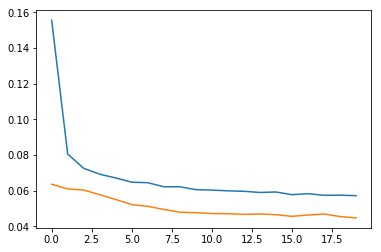

In [24]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

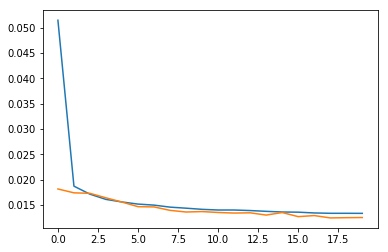

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [26]:
pred = model.predict(X_test) * theoretical_max_output

array([[3287.4807  ],
       [2848.5754  ],
       [ 605.8994  ],
       ...,
       [  28.134977],
       [ 929.9281  ],
       [  25.646893]], dtype=float32)

In [75]:
Y_test * theoretical_max_output

array([[3348.91088867],
       [2647.50610352],
       [   0.        ],
       ...,
       [   0.        ],
       [ 961.27868652],
       [   4.62359905]])

In [76]:
model_result_path = "keras_model.h5"
model.save(model_result_path)


In [77]:
!tar -zcvf keras_model.tar.gz 'keras_model.h5'

keras_model.h5


In [78]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [79]:
wml_credential = {
  "apikey": "oBhAZ0BMAHKtMjP1pCksazYUhv27eGVTJvfKlyd_GjXo",
  "iam_apikey_description": "Auto-generated for key 823b37a4-8b52-491b-a2e7-5f6cf8fb6210",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/63753724baeb4b4d9c46990d4d7706ea::serviceid:ServiceId-57adf678-b945-4f6a-9f72-a4d6a83b62b4",
  "instance_id": "e8b2e1c3-9068-458f-92ff-7b1b413da3af",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}

In [80]:
client = WatsonMachineLearningAPIClient(wml_credential)

In [81]:
tf.keras.__version__

'2.2.4-tf'

In [82]:
metadata = {
    client.repository.ModelMetaNames.AUTHOR_NAME : 'Piyush',
    client.repository.ModelMetaNames.AUTHOR_EMAIL : 'piyushkumarbehera.18je0596@cse.iitism.ac.in',
    client.repository.ModelMetaNames.NAME : 'ActiveWindPowerPrediction',
    client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.15',
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES:[{'name':'keras', 'version': '2.2.4'}],
    client.repository.ModelMetaNames.RUNTIME_NAME      : 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION   : '3.6'
}

In [83]:
stored_data = client.repository.store_model(model = 'keras_model.tar.gz',meta_props = metadata)

In [84]:
stored_data

{'metadata': {'guid': '0eb13cdf-fa3b-4708-b598-4177647e3e92',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/published_models/0eb13cdf-fa3b-4708-b598-4177647e3e92',
  'created_at': '2020-07-08T13:16:29.735Z',
  'modified_at': '2020-07-08T13:16:29.784Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'learning_configuration_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/published_models/0eb13cdf-fa3b-4708-b598-4177647e3e92/learning_configuration',
  'author': {'name': 'Piyush'},
  'name': 'ActiveWindPowerPrediction',
  'learning_iterations_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/published_models/0eb13cdf-fa3b-4708-b598-4177647e3e92/learning_iterations',
  'feedback_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/published_models/0eb13cdf-fa3b-4708-b598-4177647e3e92/feedback',
  'latest_version': 

In [85]:
guid = client.repository.get_model_uid(stored_data)

In [86]:
print(guid)

0eb13cdf-fa3b-4708-b598-4177647e3e92


In [87]:
deploy = client.deployments.create(artifact_uid=guid)



#######################################################################################

Synchronous deployment creation for uid: '0eb13cdf-fa3b-4708-b598-4177647e3e92' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='92157151-024d-476c-9919-84cbffcea543'
------------------------------------------------------------------------------------------------




In [88]:
client.deployments.list()

------------------------------------  -------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                 TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
92157151-024d-476c-9919-84cbffcea543  Artifact deployment  online  DEPLOY_SUCCESS  2020-07-08T13:16:32.580Z  tensorflow-1.15  model
------------------------------------  -------------------  ------  --------------  ------------------------  ---------------  -------------


In [89]:
deploy

{'metadata': {'guid': '92157151-024d-476c-9919-84cbffcea543',
  'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/deployments/92157151-024d-476c-9919-84cbffcea543',
  'created_at': '2020-07-08T13:16:32.580Z',
  'modified_at': '2020-07-08T13:16:32.981Z'},
 'entity': {'runtime_environment': 'python-3.6',
  'name': 'Artifact deployment',
  'scoring_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/deployments/92157151-024d-476c-9919-84cbffcea543/online',
  'deployable_asset': {'name': 'ActiveWindPowerPrediction',
   'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e8b2e1c3-9068-458f-92ff-7b1b413da3af/published_models/0eb13cdf-fa3b-4708-b598-4177647e3e92',
   'guid': '0eb13cdf-fa3b-4708-b598-4177647e3e92',
   'created_at': '2020-07-08T13:16:32.553Z',
   'type': 'model'},
  'description': 'Description of deployment',
  'status_details': {'status': 'DEPLOY_SUCCESS'},
  'model_type': 'tensorflow-1.15',

In [90]:
scoring_endpoint = client.deployments.get_scoring_url(deploy)

In [45]:
#client.deployments.delete('694002d5-5c37-43ef-975f-ab37978be6cb')

'SUCCESS'